In [25]:

#import libraries
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

#uncomment for reproducibility
#torch.manual_seed(42)
#np.random.seed(42)

# create data with positive instances (X2, Y2) and negative (X1, Y1)
#[N, F] number of instances, features
X1 = torch.randn(10000, 200) #instances, features/variables
X2 = (torch.randn(10000, 200) * 1.5) + 5
X = torch.cat([X1, X2], dim=0)
Y1 = torch.zeros(10000, 1) #negative instances
Y2 = torch.ones(10000, 1) #positive instances
Y = torch.cat([Y1, Y2], dim=0)
#[N, F] instances, features
print(X.size())
#[N, 1] instances, label [0,1]
print(Y.size())

torch.Size([20000, 200])
torch.Size([20000, 1])


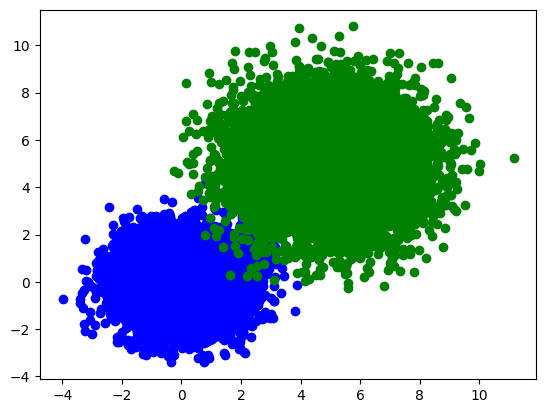

In [26]:
#plot instances
plt.scatter(X1[:, 0], X1[:, 1], color='b')
plt.scatter(X2[:, 0], X2[:, 1], color='g')

In [27]:
#define model
class Net(nn.Module):

    def __init__(self, feat_size=200, hidden_size=1000, num_labels=1, dropout=0.2):
      super().__init__()
      self.fc1 = nn.Linear(feat_size, feat_size) #Wx + b
      self.relu = nn.ReLU() #tanh, sigmoid, etc
      self.dout = nn.Dropout(dropout) #regularization
      self.fc2 = nn.Linear(feat_size, hidden_size) #Wx + b
      self.out = nn.Linear(hidden_size, num_labels) #classifier
      self.out_act = nn.Sigmoid()

    def forward(self, x):
      #[B, F] batch, features
      h1 = self.fc1(x) #linear
      #[B, F]
      h1 = self.relu(h1) # h1 = relu(Wx + b) hidden layer
      h1 = self.dout(h1) # regularize
      #[B, H] batch, hidden
      h2 = self.fc2(h1)
      h2 = self.relu(h2)
      h2 = self.dout(h2)
      #[B, 1] classifier
      logits = self.out(h2) # Wh2 + b un normalized prob
      probs = self.out_act(logits) # sigmoid [0, 1]
      return logits, probs

# model
model = Net(dropout=0.3) #ins
print(model)
#check for device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps")
#put model into the device
model = model.to(device)
#define adam optimizer
opt = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0001) 
#define binary loss
criterion = nn.BCEWithLogitsLoss() # sum y log prob(x) / y sigmoid(Wh2 +b)

Net(
  (fc1): Linear(in_features=200, out_features=200, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=200, out_features=1000, bias=True)
  (out): Linear(in_features=1000, out_features=1, bias=True)
  (out_act): Sigmoid()
)


In [28]:
print(device)

mps


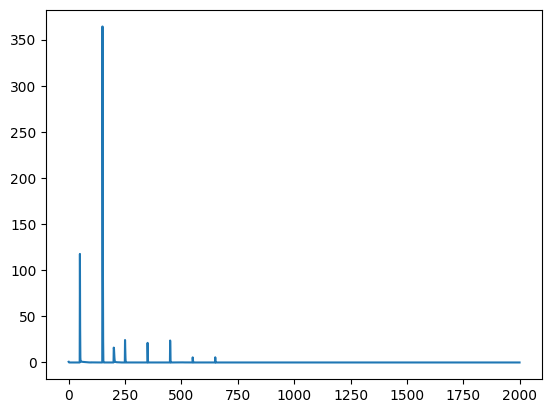

In [29]:
#define hyperparameters

e_losses = []
num_epochs = 20 # time i go over the data
batch_size=200 # n instances at  time

#2000 steps min SGD, fit in the GPU
# mini batch improves
# 1 last instances

#training loop
for e in range(num_epochs):
  model.train()
  loss_batch = []
  for beg_i in range(0, X.size(0), batch_size):
    #batch instances given batch size
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    opt.zero_grad()
    # (1) Forward
    y_logits, y_probs = model(x_batch) #theta = {wwwwwwbbb}
    # (2) Compute loss
    loss = criterion(y_logits, y_batch)
    #save loss of batch
    # i want to save every 100 steps
    loss_batch.append(loss.item())
    # (3) Compute gradients
    loss.backward()
    # (4) update weights
    opt.step()

  e_losses += loss_batch
#plot loss over epochs
plt.plot(e_losses)

In [44]:
#prediction
x_t = torch.randn(10000, 200) # y= 0
x_t = x_t.to(device)

model.eval()
y_logit, y_prob = model(x_t)
print('y=0 (mean probability)',y_prob.mean().item()) #
x_1_t = torch.randn(10000, 200) * 1.5 + 5
x_1_t = x_1_t.to(device)
y1_logit, y1_prob = model(x_1_t)
print('y=1 (mean probability)', y1_prob.mean().item())  


y=0 (mean probability) 0.0003334038774482906
y=1 (mean probability) 0.9997782707214355
